# 한국은행 의사록 어조 분석

이제 극성사전이 완성되었으므로, 이를 이용해 한국은행 의사록의 어조(tone)을 측정하도록 한다. 

우선 각 일자의 한국은행 의사록을 `sentences`로 분리한 뒤, 각 `sentences`를 다시 `ngrams`로 분리한다. 

문장별로 추출한 `ngrams`를 바탕으로 각 문장의 `tone_sentence`를 계산한다. 

문장별 `tone_sentence`가 계산됐으면, 문장을 다시 합쳐 문서(의사록)의 `tone_doc`을 구한다. 

한 날짜에는 한 문서가 있고, 따라서 한 `tone_doc`이 있으므로, 이제 이 데이터를 바탕으로 한국은행 기준금리 데이터와의 상관관계와 그래프를 확인한다. 

In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import multiprocessing as mp

import preprocessing_mp_worker as worker

## 의사록 데이터를 불러온다. 

김현진T 코드를 기반으로 minutes_ngram df를 만들 때 문장을 @@@로 split하였다. 따라서 의사록 섹션 2,3을 문장으로 나눌 때 @@@로 split해주면 충분하다. 

In [2]:
minutes_df = pd.read_pickle('./data_files/BOK_minutes/pkl/minutes_ngram.pkl')
# minutes_df = minutes_df[['date', 'minutes']]
minutes_df.loc[:, 'sections'] = minutes_df['Foreign Currency'] + minutes_df['Financial Markets']
minutes_df = minutes_df[['date', 'sections']]
minutes_df.head()

,date,sections
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...
1,2005-06-23,
2,2005-07-07,일부 위원은 6월 들어 국제유가가 크게 오르고 원화와 엔화간 동조화 현상이 뚜렷...
3,2005-08-11,일부 위원은 위안화 절상 이후 아시아 통화중 우리나라 원화의 절상폭이 가장 컸다...
4,2005-09-08,일부 위원은 최근 인도네시아 금융불안 사태가 발생한 가운데 국제 환투기세력이 인...


## 의사록 섹션 2, 3(`sections`)를 문장(`sentences`)들로 분리한다. 

In [3]:
def split_by_at_sign(text):
    return text.split('@@@')

In [4]:
%%time

# minutes_df.loc[:, 'sentences'] = minutes_df.minutes.map(lambda x: worker.tidy_sentences(x)[0])
minutes_df.loc[:, 'sentences'] = minutes_df.sections.map(split_by_at_sign)

Wall time: 13.8 ms


In [6]:
minutes_df = minutes_df.explode('sentences')
minutes_df.head()

,date,sections,sentences
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,- 6 - 동 위원은 환율이 중장기적으로 각국의 기초경제여건(fundamen...
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,다른 일부 위원은 최근 유로지역의 경제성장 실적이 예상보다 저조한 가운 데 일각에...
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,동 위원은 국내 금리가 현 수준에서 유지되고 미국 금리가 상승하는 가운 데 달러화...
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,다른 일부 위원은 최근 가계대출의 월평균 증가액이 2003년과 지난해 실적 을 크...


In [9]:
minutes_df.dropna(inplace=True) # sentences가 np.nan이라서 float으로 들어가 오류나는 경우 존재한다. 
minutes_df.date = pd.to_datetime(minutes_df.date)
minutes_df.reset_index(drop=True, inplace=True)

In [10]:
len(minutes_df)

11502

In [11]:
minutes_df.describe()

,date,sections,sentences
count,11502,11502,11502
unique,301,117,11051
top,2012-04-13 00:00:00,일부 위원은 최근 일부 기업의 해외 현지법인이 해외채권을 외평채 보다도 낮은 금리...,
freq,324,324,185
first,2005-06-09 00:00:00,NaN,NaN
last,2020-01-17 00:00:00,NaN,NaN


In [12]:
minutes_df.head()

,date,sections,sentences
0,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...
1,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,- 6 - 동 위원은 환율이 중장기적으로 각국의 기초경제여건(fundamen...
2,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,다른 일부 위원은 최근 유로지역의 경제성장 실적이 예상보다 저조한 가운 데 일각에...
3,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,동 위원은 국내 금리가 현 수준에서 유지되고 미국 금리가 상승하는 가운 데 달러화...
4,2005-06-09,일부 위원은 우리나라 경제가 일본경제 에 비해 더 나아질 특별한 요인이 없음에도 ...,다른 일부 위원은 최근 가계대출의 월평균 증가액이 2003년과 지난해 실적 을 크...


## 각 문장을 `ngrams`로 분리한다. 

In [13]:
%%time 
# Wall time: 42min 39s

with mp.Pool(processes=6) as p:
    minutes_sentences_ngrams = p.map(worker.text2ngram, minutes_df.sentences)

Wall time: 10min 46s


In [14]:
len(minutes_sentences_ngrams)

11502

## Polarity Dictionary를 불러온다. 

그리고 hawkish_dictionary와 dovish_dictionary로 나눈다. 

In [28]:
polarity_dictionary = pd.read_pickle('./data_files/results/polarity_dictionary_1.3threshold.pkl')
polarity_dictionary.head()

,hawkish,dovish,total,prob_feature_given_hawkish,prob_feature_given_dovish,polarity_score
이변/NNG,9,7,16,0.000008,0.000005,1.556266
지신/NNG,12,8,20,0.000010,0.000006,1.815644
그렉시트/NNG,17,34,51,0.000014,0.000024,0.605215
실험/NNG,19,9,28,0.000016,0.000006,2.555350
자산배분전략/NNG,10,102,112,0.000008,0.000071,0.118670


In [29]:
intensity_threshold = 1.3

hawkish_dictionary = polarity_dictionary[polarity_dictionary.polarity_score >= intensity_threshold]
hawkish_dictionary = hawkish_dictionary.index

dovish_dictionary = polarity_dictionary[polarity_dictionary.polarity_score <= 1/intensity_threshold]
dovish_dictionary = dovish_dictionary.index

In [30]:
print("hawkish dictionary 크기: ", len(hawkish_dictionary))
print("dovish dictionary 크기: ", len(dovish_dictionary))

hawkish dictionary 크기:  1743
dovish dictionary 크기:  1990


뉴스 ngram 추출을 하지 않아 사전크기가 너무 작으므로, 김현진T에게 받은 뉴스데이터의 ngram까지 추가된 hawkish/dovish dictionary를 받아 결과를 확인해보겠다. 

In [15]:
alter_hawkish_dictionary = pd.read_csv('./data_files/results/close_hawkish_dic.csv')
alter_hawkish_dictionary.set_index('Unnamed: 0', inplace=True)
alter_hawkish_dictionary = alter_hawkish_dictionary.index
alter_hawkish_dictionary

Index(['인상/NNG', '종합/NNG', '배포/NNG', '전재/NNG', '기사/NNG', '뉴스/NNG', '무단/NNG',
       '긴축/NNG', '금지/NNG', '이용/NNG',
       ...
       '예상/NNG;분위기/NNG;강하/VA', '경기순환/NNG;회복/NNG', '꼬인다/VV',
       '강력/NNG;경제/NNG;회복/NNG', '산업활동/NNG;둔화/NNG',
       'ecb/NNG;국채/NNG;매입/NNG;확대/NNG', '가격/NNG;하락/NNG;오르/VV',
       '인상/NNG;불확실성/NNG;해소/NNG', '심리/NNG;위축/NNG;하락/NNG', '면세품/NNG'],
      dtype='object', name='Unnamed: 0', length=11863)

In [16]:
alter_dovish_dictionary = pd.read_csv('./data_files/results/close_dovish_dic.csv')
alter_dovish_dictionary.set_index('Unnamed: 0', inplace=True)
alter_dovish_dictionary = alter_dovish_dictionary.index
alter_dovish_dictionary

Index(['인하/NNG', '양적완화/NNG', '대책/NNG', '금융위기/NNG', '부양/NNG', '부양책/NNG',
       '저작권자/NNG', '실물/NNG', '마이너스/NNG', '금리/NNG;인하/NNG',
       ...
       '경기/NNG;둔화/NNG;피하/VV', '경기민감물가/NNG', '까맣/VA',
       '범위/NNG국채/NNG;수익률/NNG;상승/NNG', '림프종/NNG', '인플레이션/NNG;지표/NNG;악화/NNG',
       'gdp/NNG;악화/NNG', '금리/NNG;인하/NNG;무산/NNG', '전망/NNG;상향/NNG;전망/NNG;하향/NNG',
       '국채입찰/NNG;견조/NNG'],
      dtype='object', name='Unnamed: 0', length=13171)

In [17]:
'인상/NNG' in alter_hawkish_dictionary

True

## 각 문장의 tone을 구한다. 

In [46]:
def sentence_tone(sentence_ngram_list):
    hawkish_count = 0
    dovish_count = 0
    
    for ngram in sentence_ngram_list:
        if ngram in alter_hawkish_dictionary:
            hawkish_count += 1
        elif ngram in alter_dovish_dictionary:
            dovish_count += 1
        else:
            continue
    
    if (hawkish_count + dovish_count) == 0:
        return np.nan
    
    sentence_tone = (hawkish_count - dovish_count) / (hawkish_count + dovish_count)
    
    return sentence_tone

In [48]:
sentence_tone_list = [sentence_tone(ngram_list) for ngram_list in minutes_sentences_ngrams]
len(sentence_tone_list)

42661

In [55]:
sentence_tone_df = pd.DataFrame(sentence_tone_list, columns=['sentence_tone'])
minutes_df_tone = pd.concat([minutes_df, sentence_tone_df], axis=1)

In [57]:
minutes_df_tone.dropna(inplace=True)
minutes_df_tone

,date,minutes,sentences,sentence_tone
0,2005-06-09,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,130.1...,0.000000
1,2005-06-09,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,5. 참 여 자 이 상 용 감사 정 규 영 ...,1.000000
2,2005-06-09,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"(３) 위원 토의내용 ｢국내외 경제동향｣과 관련하여, 일부 위원은 최근 소비...",1.000000
4,2005-06-09,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,또한 동 위원은 정부가 여러 차례에 걸쳐 부동산시장 안정대책을 내놓았음.,-1.000000
5,2005-06-09,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,에도 불구하고 오히려 정책의 대상이 되는 지역을 중심으로 가격상승이 지속되고 있...,-1.000000
...,...,...,...,...
42651,2020-01-17,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,- 35 - (별첨2) 2020년도 한국은행의 대정부 일시대출금 한도 및 대출조...,-1.000000
42652,2020-01-17,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,가. 대출금 한도 및 상환기한 대출 구분 회 계 별 대출금 한도 (억원) 상...,-0.333333
42654,2020-01-17,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,대출형식은 금융통화위원회가 정한 대출금 한도와 대출취급기한 내에서 정 부의 일시차...,-1.000000
42655,2020-01-17,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,- 36 - 2. 부대조건 가. 정부는 일시적인 부족자금을 ｢국고금 관리법｣에 ...,0.000000


In [198]:
minutes_df_tone.to_pickle('./data_files/results/alter_minutes_df_sentence_tone.pkl')

## 문서의 tone을 구한다. 

`.groupby('date')`를 했다. 한 날짜에 의사록이 하나 올라온다 가정. 

In [147]:
def doc_tone(sentence_tone_series):
    hawkish_count = 0
    dovish_count = 0
    
    hawkish_count = sentence_tone_series[sentence_tone_series > 0].count()
    dovish_count = sentence_tone_series[sentence_tone_series < 0].count()
    
    if (hawkish_count + dovish_count) == 0:
        return np.nan
    
    doc_tone = (hawkish_count - dovish_count) / (hawkish_count + dovish_count)
    
    return doc_tone

In [155]:
minutes_df_tone_by_date = minutes_df_tone.groupby('date')['sentence_tone'].apply(doc_tone)
minutes_df_tone_by_date = pd.DataFrame({'doc_tone': minutes_df_tone_by_date.values}, index=minutes_df_tone_by_date.index)
minutes_df_tone_by_date.dropna(inplace=True)
minutes_df_tone_by_date.tail()

,doc_tone
date,
2019-10-16,-0.514851
2019-11-29,-0.484979
2019-12-12,0.428571
2019-12-26,-0.200000
2020-01-17,-0.451613


In [164]:
minutes_df_tone_by_date = minutes_df_tone_by_date[(minutes_df_tone_by_date.doc_tone != 1) & (minutes_df_tone_by_date.doc_tone != -1)]
len(minutes_df_tone_by_date)

269

In [201]:
minutes_df_tone_by_date.to_pickle('./data_files/results/alter_minutes_df_document_tone.pkl')

## 한국은행 기준금리 데이터를 불러와 합친다. 

In [149]:
minutes_df_tone_by_date = pd.read_pickle('./data_files/results/alter_minutes_df_document_tone.pkl')
minutes_df_tone_by_date.head()

,doc_tone
date,
2005-06-09,0.321429
2005-06-23,-1.000000
2005-07-07,0.264957
2005-08-11,0.449541
2005-09-08,0.314286


In [150]:
bok_policy_rate = pd.read_csv('./data_files/BOK_2.6._base_rate.csv')
bok_policy_rate.date = pd.to_datetime(bok_policy_rate.date)
bok_policy_rate.set_index('date', inplace=True)
bok_policy_rate.head()

,base_rate
date,
2004-01-01,3.75
2004-01-02,3.75
2004-01-03,3.75
2004-01-04,3.75
2004-01-05,3.75


In [167]:
tone_and_policy_rate_df = minutes_df_tone_by_date.merge(bok_policy_rate, how='left', left_index=True, right_index=True)
tone_and_policy_rate_df.head()

,doc_tone,base_rate
date,,
2005-06-09,0.321429,3.25
2005-07-07,0.264957,3.25
2005-08-11,0.449541,3.25
2005-09-08,0.314286,3.25
2005-09-22,-0.800000,3.25


In [152]:
tone_and_policy_rate_df.to_pickle('./data_files/results/alter_tone_and_policy_rate_df.pkl')

## 상관관계 계산 및 그래프 plot

In [165]:
tone_and_policy_rate_df.corr(method='pearson')

,doc_tone,base_rate
doc_tone,1.00000,0.42309
base_rate,0.42309,1.00000


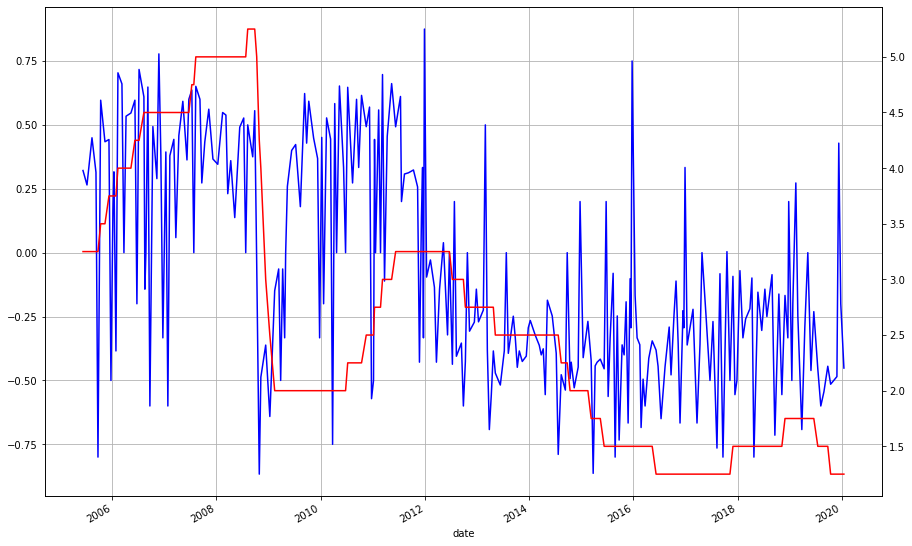

In [168]:
plt.figure(figsize=(15,10))

ax1 = tone_and_policy_rate_df.doc_tone.plot(color='blue', grid=True, label='금통위 의사록 어조')
ax2 = tone_and_policy_rate_df.base_rate.plot(color='red', grid=True, secondary_y=True, label='기준금리')

plt.show()